# salvo_compare_line_measurements

Simple notebook for loading in and plotting repeat measurements on the 200 m lines

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import pandas as pd
import datetime
import seaborn as sns
import xarray as xr

In [2]:
#salvo_data_root_path = "/mnt/g/My Drive/collaborations/SALVO/field_season_2024/data/temporary_data_analysis/SALVO-2024"
salvo_data_root_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                                    "SALVO", "data", "salvo-2024-backup", "SALVO-2024-20240619-1305")

In [3]:
def load_salvo_data_str(root_path, sites=None, dates=None, insts=None):
    """
    Loads requested salvo data into an xarray Dataset

    Parameters:
    -----------
    root_path : str
        Filesystem path to the root of the SALVO data directory
    sites : list, optional
        List of site names to load, if None, load all sites. The default is None.
    dates : list, optional
        List of datestrings ('YYYYMMDD') to load, if None, load all dates. The default is None.
    insts : list, optional
        List of instrument names to load, if None, load all instruments. The default is None.

    Returns:
    --------
    Dataset
        xarray dataset containing requested data
    """
    
    # Parse inputs
    if sites is None:
        sites = ['arm', 'beo', 'ice']
    if insts is None:
        raise NotImplementedError

    # Create list containing data arrays for each file
    df_list = []
    dirs = os.listdir(root_path)
    for dir in dirs:
        # Exclude nonselected dates
        if dates is None:
            if not re.search('^20[1,2][0-9]0[4-6][0-3][0-9]', dir):
                continue
        else:
            if not dir[:8] in dates:
                continue
        # Exclude nonselected sites
        site = dir[-3:]
        if not site in sites:
            continue

        # Parse selected sites
        dirs_site = os.listdir(os.path.join(root_path, dir))
        for inst in dirs_site:
            if (inst in insts) and not (inst=='magnaprobe'): # hack for magnaprobe data...
                files_inst = os.listdir(os.path.join(root_path, dir, inst))
                for file in files_inst:
                    if file[-7:]=='.a1.csv' and file[:5]=='salvo':
                        #print(os.path.join(root_path, dir, inst, file))
                        df_list.append(load_salvo_file(os.path.join(root_path, dir, inst, file), inst, site=site))

    # hack for preliminary magnaprobe data...
    if 'magnaprobe' in insts:
        magna_path = os.path.join(root_path, '..', '..', 'magnaprobe200mpreliminary')
        files = os.listdir(magna_path)
        for file in files:
            split_file = re.split(r'_|-|\.', file)
            site = split_file[1]
            if (site in sites) and ((dates is None) or (split_file[5] in dates)):
                df_list.append(load_salvo_file(os.path.join(magna_path, file), 'magnaprobe', site=site))
                        
    return pd.concat(df_list)
        

def load_salvo_file(file_path, inst, site=None):
    """
    Loads requested file into dataframe

    Parameters:
    -----------
    file_path : str
        path to file location
    inst : str
        string specifying type of instrument
    site : str, optional
        string specifying site. The default is None.

    Returns:
    --------
    Dataframe
        pandas dataframe with requested file
    """

    if inst=='kz-mobile':
        df = pd.read_csv(file_path, usecols=['date_akdt', 'timestamp_akdt', 'incident_solar_W_m2', 
                                             'reflected_solar_W_m2', 'site', 'location',
                                             'position', 'repetition', 'albedo'],
                         dtype={'position': 'float64', 'timestamp_akdt':'str'})
        # Convert date and time to timestamp
        # Check whether : is present in timestamp_akdt
        if not df['timestamp_akdt'].str.contains(':[0-9][0-9]').all():
            if df['timestamp_akdt'].str.contains(':[0-9][0-9]').any():
                raise RuntimeError("misformatted timestamp column in: " + file_path)
            else:
                df['timestamp_akdt'] = df['timestamp_akdt'].apply(lambda x: x[:-2]+':'+x[-2:])
        print(file_path)
        df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)
        df.drop(columns=['date_akdt'], inplace=True)
        df['wavelength'] = np.NaN
        df.set_index(['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength'], inplace=True)
        df['albedo'] = df['reflected_solar_W_m2'] / df['incident_solar_W_m2']
        df = df.melt(ignore_index=False).set_index('variable', append=True)
    if inst=='magnaprobe':
        df = pd.read_csv(file_path, parse_dates=False, usecols=['Timestamp', 'LineLocation', 'SnowDepth'])
        df['site'] = site
        df['location'] = 'line'
        df['repetition'] = 1
        df['wavelength'] = np.NaN
        df.rename(columns={'Timestamp': 'timestamp_akdt', 'LineLocation':'position', 'SnowDepth':'snow_depth_m'},
                  inplace=True)
        df['timestamp_akdt'] = pd.to_datetime(df['timestamp_akdt']+'-0800', utc=False)
        df['water_depth_m'] = -1*df['snow_depth_m'].clip(upper=0)
        df['snow_depth_m'] = df['snow_depth_m'].clip(lower=0)
        df.set_index(['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength'], inplace=True)
        df = df.melt(ignore_index=False).set_index('variable', append=True)
    return df

def load_gml_albedo(dir_path):
    files = os.listdir(dir_path)
    df_list = []
    for file in files:
        df_list.append(pd.read_csv(os.path.join(dir_path, file), skiprows=2, sep=r'\s+',
                      names=['year', 'jd', 'month', 'day', 'hour', 'minute', 'dt', 'zen', 
                             'incident_solar_W_m2', 'incident_solar_W_m2_qc', 
                             'reflected_solar_W_m2', 'reflected_solar_W_m2_qc',],
                      usecols=np.arange(12)))
    df_gml = pd.concat(df_list, ignore_index=True)
    df_gml['timestamp_utc'] = pd.to_datetime(df_gml[['year', 'month', 'day', 'hour', 'minute']], utc=True)
    df_gml.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'jd', 'dt'], inplace=True)
    df_gml.set_index('timestamp_utc', inplace=True)
    return df_gml
                                   

In [4]:
dir_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "gml_albedo_rack")
df_gml = load_gml_albedo(dir_path)

In [5]:
df = load_salvo_data_str(salvo_data_root_path, dates=None,insts=['kz-mobile','magnaprobe'], sites=['arm', 'beo', 'ice'])

C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240417-ice\kz-mobile\salvo_ice_all_kz-mobile_20240417.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240419-arm\kz-mobile\salvo_arm_all_kz-mobile_20240419.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240420-beo\kz-mobile\salvo_beo_all_kz-mobile_20240420.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240421-ice\kz-mobile\salvo_ice_all_kz-mobile_20240421.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240523-beo\kz-mobile\salvo_beo_line_kz-mobile_20240523.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240524-arm\kz-mobile\salvo_arm_lin

C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_32496\658938343.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)
C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_32496\658938343.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)


C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240526-ice\kz-mobile\salvo_ice_all_kz-mobile_20240526.00.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240527-arm\kz-mobile\salvo_arm_all_kz-mobile_20240527.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240527-arm\kz-mobile\salvo_arm_library_kz-mobile_20240527.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240527-arm\kz-mobile\salvo_arm_line_kz-mobile_20240527.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240529-arm\kz-mobile\salvo_arm_all_kz-mobile_20240529.a1.csv


C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_32496\658938343.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)
C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_32496\658938343.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)
C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_32496\658938343.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_ak

C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240529-beo\kz-mobile\salvo_beo_line_kz-mobile_20240529.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240530-ice\kz-mobile\salvo_ice_line_kz-mobile_20240530.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240602-beo\kz-mobile\salvo_beo_all_kz-mobile_20240602.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240603-arm\kz-mobile\salvo_arm_line_kz-mobile_20240603.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240604-ice\kz-mobile\salvo_ice_line_kz-mobile_20240604.a1.csv


C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_32496\658938343.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)


C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240605-arm\kz-mobile\salvo_arm_all_kz-mobile_20240605.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240605-beo\kz-mobile\salvo_beo_all_kz-mobile_20240605.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240606-arm\kz-mobile\salvo_arm_all_kz-mobile_20240606.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240607-ice\kz-mobile\salvo_ice_all_kz-mobile_20240607.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240608-beo\kz-mobile\salvo_beo_all_kz-mobile_20240608.a1.csv


C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_32496\658938343.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)
C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_32496\658938343.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)
C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_32496\658938343.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_ak

C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240610-arm\kz-mobile\salvo_arm_all_kz-mobile_20240610.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240610-ice\kz-mobile\salvo_ice_all_kz-mobile_20240610.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240611-beo\kz-mobile\salvo_beo_all_kz-mobile_20240611.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240612-arm\kz-mobile\salvo_arm_all_kz-mobile_20240612.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240613-ice\kz-mobile\salvo_ice_all_kz-mobile_20240613.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240614-beo\kz-mobile\salvo_beo_all_

In [23]:
# Load CAFS output
cafs_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "CAFS", "Utqiagvik_h0_lnd.nc")
ds_cafs = xr.load_dataset(cafs_path)
df_cafs = ds_cafs[['FSDS', 'FSNO_EFF', 'FSR', 'SNOWDP', 'SNOW_DEPTH']].squeeze().to_dataframe()
df_cafs['timestamp_utc'] = df_cafs.index.tz_localize('UTC')
df_cafs.set_index('timestamp_utc', inplace=True)
df_cafs['albedo'] = df_cafs['FSR']/df_cafs['FSDS']

In [107]:
# Load NSA data
nsa_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "nsaqcrad", "*.cdf")
ds_nsa = xr.open_mfdataset(nsa_path)

In [116]:
varnames = ['BestEstimate_down_short_hemisp', 'up_short_hemisp',
            'down_long_hemisp', 'up_long_hemisp',
            'Temp_Air', 'wind_speed']
da_list = []
for varname in varnames:
    da_list.append(ds_nsa[varname].where(ds_nsa['qc_'+varname]==0))
df_nsa = xr.merge(da_list).to_dataframe()
df_nsa['timestamp_utc'] = df_nsa.index.tz_localize('UTC')
df_nsa.set_index('timestamp_utc', inplace=True)
df_nsa['albedo'] = df_nsa['up_short_hemisp']/df_nsa['BestEstimate_down_short_hemisp']

In [117]:
df_nsa

,BestEstimate_down_short_hemisp,up_short_hemisp,down_long_hemisp,up_long_hemisp,Temp_Air,wind_speed,albedo
timestamp_utc,,,,,,,
2024-04-14 00:00:00+00:00,475.700409,386.747192,163.757797,247.827103,-16.100012,9.990,0.813006
2024-04-14 00:01:00+00:00,475.661591,387.132111,163.801895,247.749207,-16.100012,9.740,0.813881
2024-04-14 00:02:00+00:00,475.058105,386.395996,163.970001,247.734207,-16.100012,9.800,0.813366
2024-04-14 00:03:00+00:00,474.920807,386.888611,163.676804,247.689697,-16.100012,9.810,0.814638
2024-04-14 00:04:00+00:00,474.204987,385.918701,163.557098,247.580002,-16.100012,10.150,0.813823
...,...,...,...,...,...,...,...
2024-06-20 23:55:00+00:00,653.634338,118.401703,249.804199,360.975708,2.265008,4.423,0.181144
2024-06-20 23:56:00+00:00,653.222351,118.342201,249.830902,361.626099,2.458002,4.537,0.181167
2024-06-20 23:57:00+00:00,651.611145,118.209000,249.875397,361.089203,2.097986,5.052,0.181410


In [15]:
s_times = df.xs(('line', 'albedo'), level=('location', 'variable')).index.get_level_values('timestamp_akdt').to_series()
s_times.index = s_times.index.normalize()
s_times.index.name = 'date_akdt'
df_times = s_times.reset_index()
df_times['time_of_day'] = df_times['timestamp_akdt'] - df_times['date_akdt']
print('Average time of day that line albedo measurements were made:')
df_times['time_of_day'].mean()
#df_temp.index = df_temp.index.set_levels(df_temp.index.levels[0].normalize(), level=0, verify_integrity=False)

Average time of day that line albedo measurements were made:


Timedelta('0 days 14:24:14.520547945')

In [17]:
start = '2024-05-20'
end = '2024-06-19'
df_temp = df_gml.copy()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.groupby(df_temp.index.normalize())['zen'].agg('idxmin')[start:end].reset_index()
df_temp['time_of_day'] = df_temp['zen'] - df_temp['timestamp_akdt']
print('Average time of day of minimum solar zenith angle ' + start + ' to ' + end)
df_temp['time_of_day'].mean()

Average time of day of minimum solar zenith angle 2024-05-20 to 2024-06-19


Timedelta('0 days 14:21:23.225806451')

In [18]:
def select_data(df, sel_dict):
    df_temp = df.xs(tuple(sel_dict.values()), level=tuple(sel_dict.keys()))
    #df_temp.attrs = sel_dict
    df_temp = df_temp.reset_index()
    df_temp['date_akdt'] = df_temp['timestamp_akdt'].dt.date
    df_temp = pd.merge(df_temp.groupby(['date_akdt', 'position'])['value'].mean(),
                       df_temp[['date_akdt', 'timestamp_akdt']].groupby(
                           'date_akdt').mean().rename(columns={'timestamp_akdt':'meantime_akdt'}),
                       left_index=True, right_index=True)
    df_temp.attrs = sel_dict
    return df_temp

In [19]:
def line_date_agg(df, variable, time_of_day='14:24:00'):
    df_temp = df.xs(('line', variable), level=('location', 'variable'))
    df_temp = df_temp.reset_index()
    df_temp['date_akdt'] = pd.to_datetime(df_temp['timestamp_akdt'].dt.date) + pd.Timedelta(time_of_day)
    df_temp = pd.merge(df_temp.groupby(['site', 'date_akdt', 'position'])['value'].mean(),
                       df_temp[['site', 'date_akdt', 'timestamp_akdt']].groupby(
                           ['site', 'date_akdt']).mean(),
                       left_index=True, right_index=True)
    df_temp = df_temp.rename(columns={'value':variable, 'timestamp_akdt':'meantime_akdt'})
    return df_temp

C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_32496\1339360168.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['albedo'] = df_temp['reflected_solar_W_m2'] / df_temp['incident_solar_W_m2']


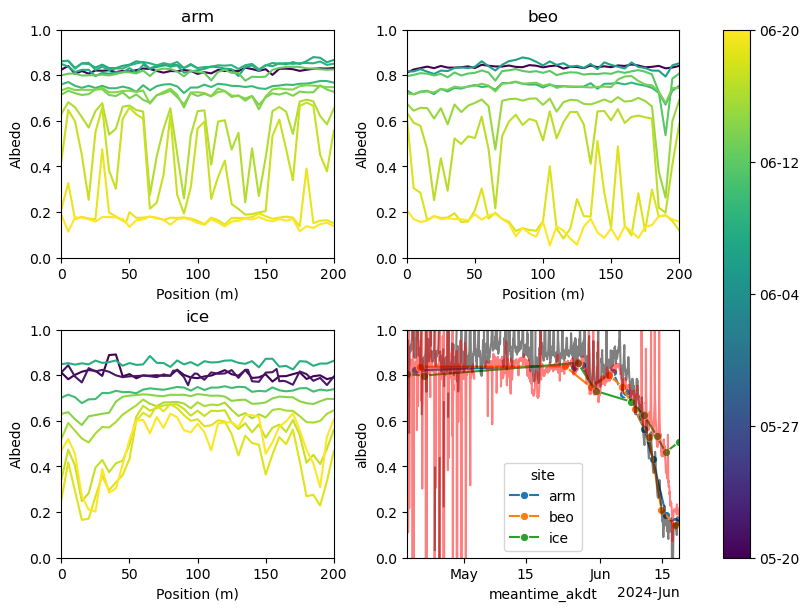

In [118]:
# Plot all albedo lines albedo
color_start_date = pd.Timestamp('2024-05-20T00:00:00-0800')
color_end_date = pd.Timestamp('2024-06-20T00:00:00-0800')

df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
df_temp['timestamp_cbar'] = (df_temp['meantime_akdt'] - color_start_date)/(color_end_date - color_start_date)

#df_temp = df_temp.xs(site, level='site').reset_index()


f, axs = plt.subplots(2, 2, figsize=(8, 6), layout='constrained')

site = 'arm'
sns.lineplot(data=df_temp.xs(site, level='site').reset_index(), x='position', y='albedo', 
             hue='timestamp_cbar', palette='viridis', ax=axs[0,0])
axs[0,0].get_legend().remove()
axs[0,0].set_title(site)
axs[0,0].set_ylim([0, 1.0])
axs[0,0].set_xlim([0, 200])
axs[0,0].set_xlabel('Position (m)')
axs[0,0].set_ylabel('Albedo')

site = 'beo'
sns.lineplot(data=df_temp.xs(site, level='site').reset_index(), x='position', y='albedo', 
             hue='timestamp_cbar', palette='viridis', ax=axs[0,1])
axs[0,1].get_legend().remove()
axs[0,1].set_title(site)
axs[0,1].set_ylim([0, 1.0])
axs[0,1].set_xlim([0, 200])
axs[0,1].set_xlabel('Position (m)')
axs[0,1].set_ylabel('Albedo')

site = 'ice'
sns.lineplot(data=df_temp.xs(site, level='site').reset_index(), x='position', y='albedo', 
             hue='timestamp_cbar', palette='viridis', ax=axs[1,0])
axs[1,0].get_legend().remove()
axs[1,0].set_title(site)
axs[1,0].set_ylim([0, 1.0])
axs[1,0].set_xlim([0, 200])
axs[1,0].set_xlabel('Position (m)')
axs[1,0].set_ylabel('Albedo')

# Comparison
sns.lineplot(data=df_temp.groupby(['site', 'date_akdt']).mean(), 
             x='meantime_akdt', y='albedo', hue='site', ax=axs[1,1],
            marker='o')
# hourly albedo rack
df_temp = df_gml.query("(incident_solar_W_m2_qc==0) and (reflected_solar_W_m2_qc==0)")
df_temp['albedo'] = df_temp['reflected_solar_W_m2'] / df_temp['incident_solar_W_m2']
df_temp = df_temp['albedo'].resample('1h').mean()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[1,1].plot('timestamp_akdt', 'albedo', data=df_temp, c='k', alpha=0.5)

# hourly nsa albedo
df_temp = df_nsa['albedo'].resample('1h').mean()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[1,1].plot('timestamp_akdt', 'albedo', data=df_temp, c='r', alpha=0.5)

axs[1,1].set_xlim([df.index.get_level_values('timestamp_akdt').min(),
            df.index.get_level_values('timestamp_akdt').max()])
axs[1,1].set_ylim(0, 1.0)
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1,1].xaxis.set_major_locator(locator)
axs[1,1].xaxis.set_major_formatter(formatter)


cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0,
                            vmax=1.0)

cbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
           ax=axs, orientation='vertical')

n_ticks = 5
cbar.set_ticks(np.linspace(0.0, 1.0, num=n_ticks))
cbar.ax.set_yticklabels(pd.date_range(start=color_start_date, end=color_end_date,
              periods=n_ticks).strftime('%m-%d'))

plt.show()

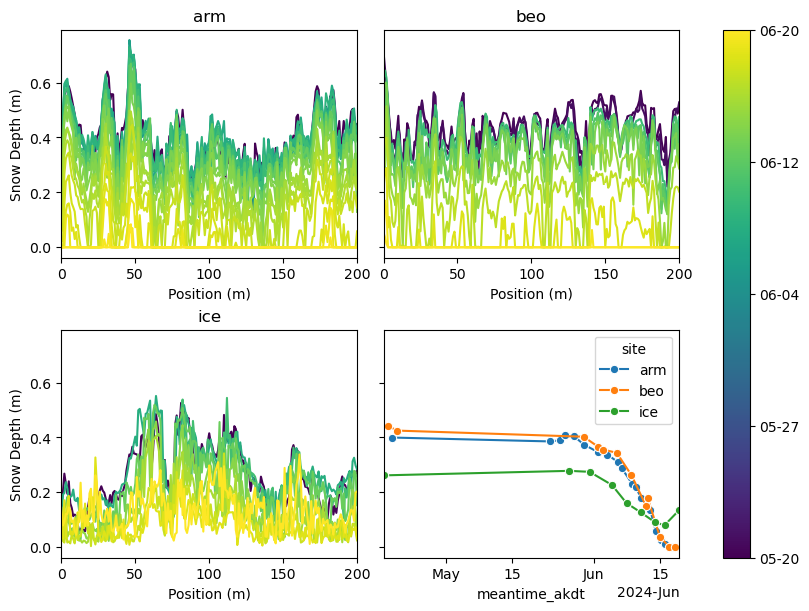

In [22]:
# Plot all albedo lines snow depth
color_start_date = pd.Timestamp('2024-05-20T00:00:00-0800')
color_end_date = pd.Timestamp('2024-06-20T00:00:00-0800')

df_temp = line_date_agg(df, 'snow_depth_m')
df_temp = df_temp.query('position != -999.0')
df_temp['timestamp_cbar'] = (df_temp['meantime_akdt'] - color_start_date)/(color_end_date - color_start_date)

#df_temp = df_temp.xs(site, level='site').reset_index()


f, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, layout='constrained')

site = 'arm'
sns.lineplot(data=df_temp.xs(site, level='site').reset_index(), x='position', y='snow_depth_m', 
             hue='timestamp_cbar', palette='viridis', ax=axs[0,0])
axs[0,0].get_legend().remove()
axs[0,0].set_title(site)
axs[0,0].set_xlim([0, 200])
axs[0,0].set_xlabel('Position (m)')
axs[0,0].set_ylabel('Snow Depth (m)')

site = 'beo'
sns.lineplot(data=df_temp.xs(site, level='site').reset_index(), x='position', y='snow_depth_m', 
             hue='timestamp_cbar', palette='viridis', ax=axs[0,1])
axs[0,1].get_legend().remove()
axs[0,1].set_title(site)
axs[0,1].set_xlim([0, 200])
axs[0,1].set_xlabel('Position (m)')
axs[0,1].set_ylabel('Snow Depth (m)')

site = 'ice'
sns.lineplot(data=df_temp.xs(site, level='site').reset_index(), x='position', y='snow_depth_m', 
             hue='timestamp_cbar', palette='viridis', ax=axs[1,0])
axs[1,0].get_legend().remove()
axs[1,0].set_title(site)
axs[1,0].set_xlim([0, 200])
axs[1,0].set_xlabel('Position (m)')
axs[1,0].set_ylabel('Snow Depth (m)')

# Comparison
sns.lineplot(data=df_temp.groupby(['site', 'date_akdt']).mean(), 
             x='meantime_akdt', y='snow_depth_m', hue='site', ax=axs[1,1],
            marker='o')
axs[1,1].set_xlim([df.index.get_level_values('timestamp_akdt').min(),
            df.index.get_level_values('timestamp_akdt').max()])
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1,1].xaxis.set_major_locator(locator)
axs[1,1].xaxis.set_major_formatter(formatter)


cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0,
                            vmax=1.0)

cbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
           ax=axs, orientation='vertical')

n_ticks = 5
cbar.set_ticks(np.linspace(0.0, 1.0, num=n_ticks))
cbar.ax.set_yticklabels(pd.date_range(start=color_start_date, end=color_end_date,
              periods=n_ticks).strftime('%m-%d'))

plt.show()

In [24]:
# explore albedo vs snow depth
df_temp = pd.merge(line_date_agg(df, 'albedo'),
                   line_date_agg(df, 'snow_depth_m'),
                   left_index=True, right_index=True)

In [13]:
df_temp

albedo  \
site date_akdt           position             
arm  2024-04-19 14:24:00 0.0       0.824532   
                         5.0       0.840743   
                         10.0      0.805988   
                         15.0      0.818494   
                         20.0      0.807242   
...                                     ...   
ice  2024-06-18 14:24:00 180.0     0.472434   
                         185.0     0.413428   
                         190.0     0.308696   
                         195.0     0.530728   
                         200.0     0.604758   

                                                      meantime_akdt_x  \
site date_akdt           position                                       
arm  2024-04-19 14:24:00 0.0      2024-04-19 13:27:57.073170688-08:00   
                         5.0      2024-04-19 13:27:57.073170688-08:00   
                         10.0     2024-04-19 13:27:57.073170688-08:00   
                         15.0     2024-04-19 13:27:57.073170688-08:00   
                         20.0     2024-04-19 13:27:57.073170688-08:00   
...                                                               ...   
ice  2024-06-18 14:24:00 180.0    2024-06-18 13:54:05.454545152-08:00   
                         185.0    2024-06-18 13:54:05.454545152-08:00   
                         190.0    2024-06-18 13:54:05.454545152-08:00   
                         195.0    2024-06-18 13:54:05.454545152-08:00   
                         200.0    2024-06-18 13:54:05.454545152-08:00   

                                   snow_depth_m  \
site date_akdt           position                 
arm  2024-04-19 14:24:00 0.0              0.477   
                         5.0              0.587   
                         10.0             0.436   
                         15.0             0.386   
                         20.0             0.367   
...                                         ...   
ice  2024-06-18 14:24:00 180.0            0.099   
                         185.0            0.088   
                         190.0            0.104   
                         195.0            0.118   
                         200.0            0.203   

                                                      meantime_akdt_y  
site date_akdt           position                                      
arm  2024-04-19 14:24:00 0.0      2024-04-19 11:10:25.287014912-08:00  
                         5.0      2024-04-19 11:10:25.287014912-08:00  
                         10.0     2024-04-19 11:10:25.287014912-08:00  
                         15.0     2024-04-19 11:10:25.287014912-08:00  
                         20.0     2024-04-19 11:10:25.287014912-08:00  
...                                                               ...  
ice  2024-06-18 14:24:00 180.0    2024-06-18 13:32:30.502139392-08:00  
                         185.0    2024-06-18 13:32:30.502139392-08:00  
                         190.0    2024-06-18 13:32:30.502139392-08:00  
                         195.0    2024-06-18 13:32:30.502139392-08:00  
                         200.0    2024-06-18 13:32:30.502139392-08:00  

[1117 rows x 4 columns]

In [14]:
df_temp.groupby(level=['site','date_akdt']).mean()

albedo                     meantime_akdt_x  \
site date_akdt                                                           
arm  2024-04-19 14:24:00  0.821019 2024-04-19 13:27:57.073170688-08:00   
     2024-05-24 14:24:00  0.843656 2024-05-24 15:58:05.714285824-08:00   
     2024-05-25 14:24:00  0.834529 2024-05-25 14:57:23.414634240-08:00   
     2024-05-27 14:24:00  0.844855 2024-05-27 12:32:21.951219456-08:00   
     2024-05-29 14:24:00  0.752966 2024-05-29 15:30:24.878048768-08:00   
     2024-06-03 14:24:00  0.812294 2024-06-03 13:47:57.209302528-08:00   
     2024-06-05 14:24:00  0.715893 2024-06-05 17:58:36.774193664-08:00   
     2024-06-06 14:24:00  0.725462 2024-06-06 14:40:39.512195072-08:00   
     2024-06-10 14:24:00  0.564789 2024-06-10 15:15:26.341463552-08:00   
     2024-06-12 14:24:00  0.433688 2024-06-12 13:27:13.170731776-08:00   
     2024-06-15 14:24:00  0.188807 2024-06-15 14:28:55.714285568-08:00   
     2024-06-17 14:24:00  0.160143 2024-06-17 13:12:20.487804672-08:00   
beo  2024-04-20 14:24:00  0.836935 2024-04-20 14:21:27.804878080-08:00   
     2024-05-29 14:24:00  0.747160 2024-05-29 12:22:39.622641408-08:00   
     2024-06-02 14:24:00  0.800134    2024-06-02 16:41:20.400000-08:00   
     2024-06-05 14:24:00  0.749902 2024-06-05 13:17:52.857142784-08:00   
     2024-06-08 14:24:00  0.650569 2024-06-08 13:59:49.756097536-08:00   
     2024-06-11 14:24:00  0.534430 2024-06-11 16:31:28.636363520-08:00   
     2024-06-14 14:24:00  0.210475 2024-06-14 13:25:01.463414528-08:00   
     2024-06-17 14:24:00  0.142143    2024-06-17 14:51:03.600000-08:00   
ice  2024-04-17 14:24:00  0.804236 2024-04-17 16:28:40.851064064-08:00   
     2024-05-26 14:24:00  0.853458 2024-05-26 13:16:13.170731776-08:00   
     2024-05-30 14:24:00  0.731087 2024-05-30 13:47:54.339622656-08:00   
     2024-06-07 14:24:00  0.684469 2024-06-07 13:18:24.285714432-08:00   
     2024-06-10 14:24:00  0.627305 2024-06-10 12:34:48.292682752-08:00   
     2024-06-13 14:24:00  0.534472 2024-06-13 11:39:54.146341376-08:00   
     2024-06-15 14:24:00  0.462089 2024-06-15 11:42:37.674418688-08:00   
     2024-06-18 14:24:00  0.507229 2024-06-18 13:54:05.454545152-08:00   

                          snow_depth_m                     meantime_akdt_y  
site date_akdt                                                              
arm  2024-04-19 14:24:00      0.405585 2024-04-19 11:10:25.287014912-08:00  
     2024-05-24 14:24:00      0.409286 2024-05-24 15:14:57.820348416-08:00  
     2024-05-25 14:24:00      0.403268 2024-05-25 15:02:19.848009984-08:00  
     2024-05-27 14:24:00      0.402375 2024-05-27 12:39:41.045423104-08:00  
     2024-05-29 14:24:00      0.369780 2024-05-29 15:13:32.946716416-08:00  
     2024-06-03 14:24:00      0.327146 2024-06-03 13:52:46.845572096-08:00  
     2024-06-05 14:24:00      0.298415 2024-06-05 16:31:55.483681536-08:00  
     2024-06-06 14:24:00      0.281854 2024-06-06 14:07:58.912785920-08:00  
     2024-06-10 14:24:00      0.167098 2024-06-10 14:40:06.965174016-08:00  
     2024-06-12 14:24:00      0.115024 2024-06-12 13:02:09.096417792-08:00  
     2024-06-15 14:24:00      0.011427 2024-06-15 14:03:22.831138560-08:00  
     2024-06-17 14:24:00      0.000000 2024-06-17 12:48:46.699851008-08:00  
beo  2024-04-20 14:24:00      0.430317 2024-04-20 13:38:45.965373184-08:00  
     2024-05-29 14:24:00      0.415732 2024-05-29 13:45:59.744179200-08:00  
     2024-06-02 14:24:00      0.352829    2024-06-02 16:28:09.053632-08:00  
     2024-06-05 14:24:00      0.348195 2024-06-05 12:26:26.781393152-08:00  
     2024-06-08 14:24:00      0.267195 2024-06-08 14:23:37.880945408-08:00  
     2024-06-11 14:24:00      0.152967 2024-06-11 16:23:57.304133376-08:00  
     2024-06-14 14:24:00      0.034390 2024-06-14 13:10:46.136915456-08:00  
     2024-06-17 14:24:00      0.001293 2024-06-17 14:54:16.653880576-08:00  
ice  2024-04-17 14:24:00      0.265575 2024-04-17 16:58:24.898009856-08:00  
     2024-05-26 14:24:00      0.2647

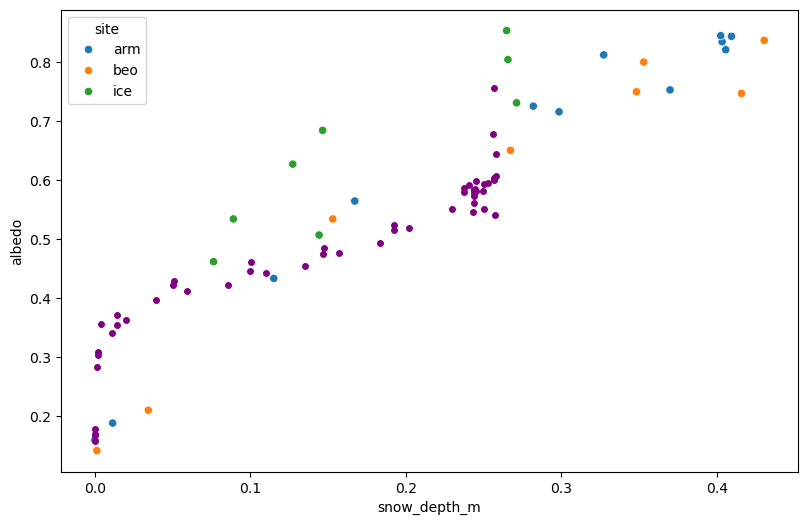

In [32]:
f = plt.figure(figsize=(9.5, 6))

sns.scatterplot(x='snow_depth_m', y='albedo', hue='site', data=df_temp.groupby(level=['site','date_akdt']).mean())#df_temp.reset_index())
plt.scatter(x='SNOWDP', y='albedo', data=df_cafs, color='purple', s=16)


In [61]:
bare_threshold = 0.05

df_temp = line_date_agg(df, 'snow_depth_m')
df_temp.reset_index(inplace=True)
df_temp.set_index(['site','meantime_akdt','position'], inplace=True)
df_temp = (df_temp['snow_depth_m'] > bare_threshold).groupby(level=['site', 'meantime_akdt']).mean()
df_temp.rename('snow_fraction_NOT_TRUSTWORTHY', inplace=True)
df_temp.reset_index()

,site,meantime_akdt,snow_fraction_NOT_TRUSTWORTHY
0,arm,2024-04-19 11:10:25.287014912-08:00,1.000000
1,arm,2024-05-22 14:59:04.833731584-08:00,0.995025
2,arm,2024-05-24 15:14:57.820348416-08:00,1.000000
3,arm,2024-05-25 15:02:19.848009984-08:00,1.000000
4,arm,2024-05-27 12:39:41.045423104-08:00,0.995025
5,arm,2024-05-29 15:13:32.946716416-08:00,1.000000
6,arm,2024-06-01 12:05:43.560596992-08:00,1.000000
7,arm,2024-06-03 13:52:46.845572096-08:00,0.995025
8,arm,2024-06-05 16:31:55.483681536-08:00,1.000000
9,arm,2024-06-06 14:07:58.912785920-08:00,0.995025


C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_32496\2626687127.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['albedo'] = df_temp['reflected_solar_W_m2'] / df_temp['incident_solar_W_m2']


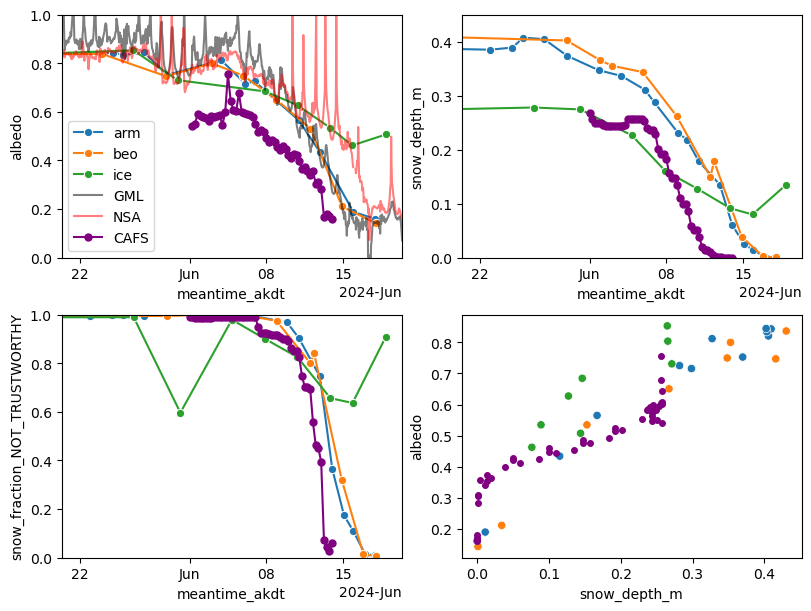

In [119]:
# Compare with CAFS
start_date = pd.Timestamp('2024-05-20T00:00:00-0800')
end_date = pd.Timestamp('2024-06-20T00:00:00-0800')
bare_threshold = 0.05

f, axs = plt.subplots(2, 2, figsize=(8, 6), layout='constrained')

# Albedo
# Line
df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
sns.lineplot(data=df_temp.groupby(['site', 'date_akdt']).mean(), 
             x='meantime_akdt', y='albedo', hue='site', ax=axs[0,0],
            marker='o')
# hourly albedo rack
df_temp = df_gml.query("(incident_solar_W_m2_qc==0) and (reflected_solar_W_m2_qc==0)")
df_temp['albedo'] = df_temp['reflected_solar_W_m2'] / df_temp['incident_solar_W_m2']
df_temp = df_temp['albedo'].resample('1h').mean()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[0,0].plot('timestamp_akdt', 'albedo', data=df_temp, c='k', alpha=0.5)
# NSA albedo
df_temp = df_nsa['albedo'].resample('1h').mean()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[0,0].plot('timestamp_akdt', 'albedo', data=df_temp, c='r', alpha=0.5)

# CAFS
df_temp = df_cafs['albedo']
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[0,0].plot('timestamp_akdt', 'albedo', data=df_temp, c='purple', marker='o', markersize=5)

axs[0,0].set_xlim([start_date, end_date])
axs[0,0].set_ylim(0, 1.0)
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[0,0].xaxis.set_major_locator(locator)
axs[0,0].xaxis.set_major_formatter(formatter)

handles, labels = axs[0,0].get_legend_handles_labels()
labels[3] = 'GML'
labels[4] = 'NSA'
labels[5] = 'CAFS'
axs[0,0].legend(handles, labels)

# Mean snow depth
# Line
df_temp = line_date_agg(df, 'snow_depth_m')
df_temp = df_temp.query('position != -999.0')
sns.lineplot(data=df_temp.groupby(['site', 'date_akdt']).mean(), 
             x='meantime_akdt', y='snow_depth_m', hue='site', ax=axs[0,1],
            marker='o', legend=False)
# CAFS
df_temp = df_cafs['SNOWDP']
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[0,1].plot('timestamp_akdt', 'SNOWDP', data=df_temp, c='purple', marker='o', markersize=5)

axs[0,1].set_xlim([start_date, end_date])
axs[0,1].set_ylim(0, 0.45)
axs[0,1].xaxis.set_major_locator(locator)
axs[0,1].xaxis.set_major_formatter(formatter)

# Snow fraction
# Line
df_temp = line_date_agg(df, 'snow_depth_m')
df_temp.reset_index(inplace=True)
df_temp.set_index(['site', 'meantime_akdt', 'position'], inplace=True)
df_temp = (df_temp['snow_depth_m'] > bare_threshold).groupby(level=['site', 'meantime_akdt']).mean()
df_temp.rename('snow_fraction_NOT_TRUSTWORTHY', inplace=True)
sns.lineplot(data=df_temp.reset_index(), 
             x='meantime_akdt', y='snow_fraction_NOT_TRUSTWORTHY', hue='site', ax=axs[1,0],
            marker='o', legend=False)
# CAFS
df_temp = df_cafs['FSNO_EFF']
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[1,0].plot('timestamp_akdt', 'FSNO_EFF', data=df_temp, c='purple', marker='o', markersize=5)

axs[1,0].set_xlim([start_date, end_date])
axs[1,0].set_ylim(0, 1.0)
axs[1,0].xaxis.set_major_locator(locator)
axs[1,0].xaxis.set_major_formatter(formatter)

# Albedo vs. snow depth
# Line
df_temp = pd.merge(line_date_agg(df, 'albedo'),
                   line_date_agg(df, 'snow_depth_m'),
                   left_index=True, right_index=True)
sns.scatterplot(x='snow_depth_m', y='albedo', hue='site', legend=False,
                data=df_temp.groupby(level=['site','date_akdt']).mean(), ax=axs[1,1])
# CAFS
axs[1,1].scatter(x='SNOWDP', y='albedo', data=df_cafs, color='purple', s=16)

plt.show()

<Axes: xlabel='meantime_akdt_start', ylabel='snow_melt_rate_m_per_day'>

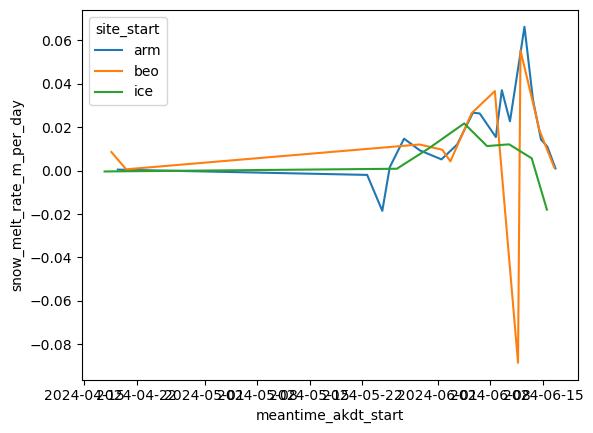

In [103]:
df_temp = line_date_agg(df, 'snow_depth_m')
df_temp = df_temp.groupby(level=['site', 'date_akdt']).mean().sort_index().reset_index()
df_temp2 = df_temp.copy()
df_temp2.index = df_temp2.index + 1
df_temp = pd.merge(df_temp2, df_temp, left_index=True, right_index=True, suffixes=('_start', '_end'))
df_temp = df_temp.loc[df_temp['site_start'] == df_temp['site_end']]
df_temp['snow_depth_m_delta'] = df_temp['snow_depth_m_end'] - df_temp['snow_depth_m_start']
df_temp['snow_melt_rate_m_per_day'] = -1*df_temp['snow_depth_m_delta'] / (
    (df_temp['meantime_akdt_end'] - df_temp['meantime_akdt_start'])/pd.Timedelta(days=1))

#_temp
#(df_temp['meantime_akdt_end'] - df_temp['meantime_akdt_start'])/pd.Timedelta(days=1)
sns.lineplot(x='meantime_akdt_start', y='snow_melt_rate_m_per_day', hue='site_start', data=df_temp)

In [123]:
# Compare arm incident with GML incident
#df_comp = 
df_temp = df_gml.query("incident_solar_W_m2_qc==0")
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp['incident_solar_W_m2'].rename('gml_incident')
df_temp2 = df.xs(('arm', 'incident_solar_W_m2'), level=('site', 'variable')).droplevel(['location', 'position', 'repetition', 'wavelength'])
df_temp2 = df_temp2.rename(columns={'value': 'salvo_arm_incident'})
df_temp3 = df_nsa.copy()
df_temp3.index = df_temp3.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp3 = df_temp3['BestEstimate_down_short_hemisp'].rename('nsa_incident')

df_comp = df_temp2.join(df_temp)
df_comp = df_comp.join(df_temp3)
df_comp['diff_gml'] = df_comp['salvo_arm_incident'] - df_comp['gml_incident']
df_comp['diff_nsa'] = df_comp['salvo_arm_incident'] - df_comp['nsa_incident']

In [130]:
df_comp['diff_gml'].describe()

count    678.000000
mean      10.033982
std       41.254256
min     -277.750000
25%        1.827500
50%       13.585000
75%       19.890000
max      370.740000
Name: diff_gml, dtype: float64

In [125]:
df_comp['diff_nsa'].describe()

count    678.000000
mean      -1.627554
std       44.741867
min     -258.390039
25%      -11.162433
50%       -1.889803
75%       11.479468
max      409.290110
Name: diff_nsa, dtype: float64

Text(0.5, 0, 'salvo-gml incident (W/m2')

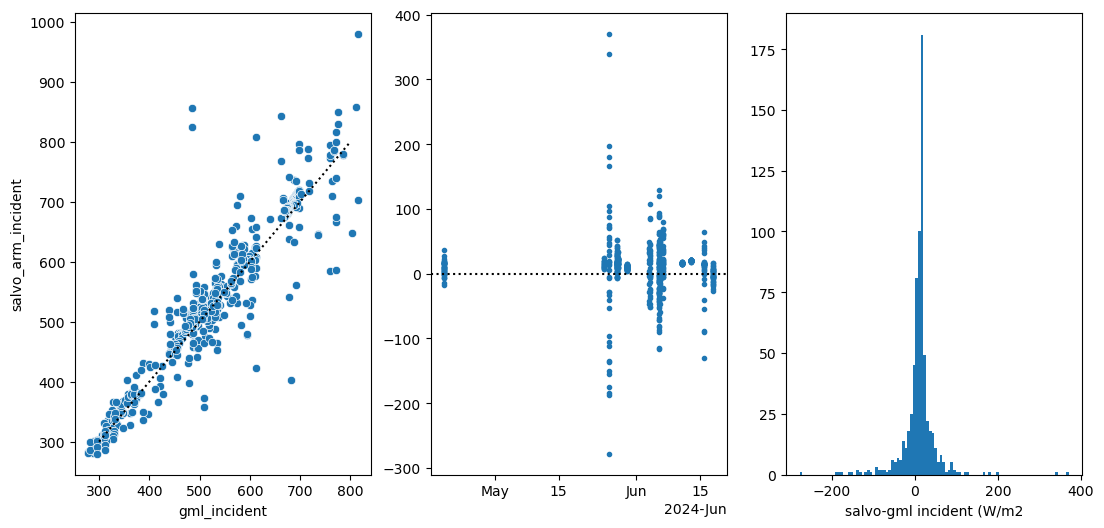

In [126]:
f, axs = plt.subplots(1, 3, figsize=(13, 6))

sns.scatterplot(data=df_comp, x='gml_incident', y='salvo_arm_incident', ax=axs[0])
axs[0].plot([300, 800], [300, 800], 'k:')

axs[1].plot(df_comp['diff_gml'], marker='.', linestyle='')
axs[1].axhline(y=0, color='k', linestyle=':')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

axs[2].hist(df_comp['diff_gml'], bins=100)
axs[2].set_xlabel('salvo-gml incident (W/m2')

Text(0.5, 0, 'salvo-nsa incident (W/m2')

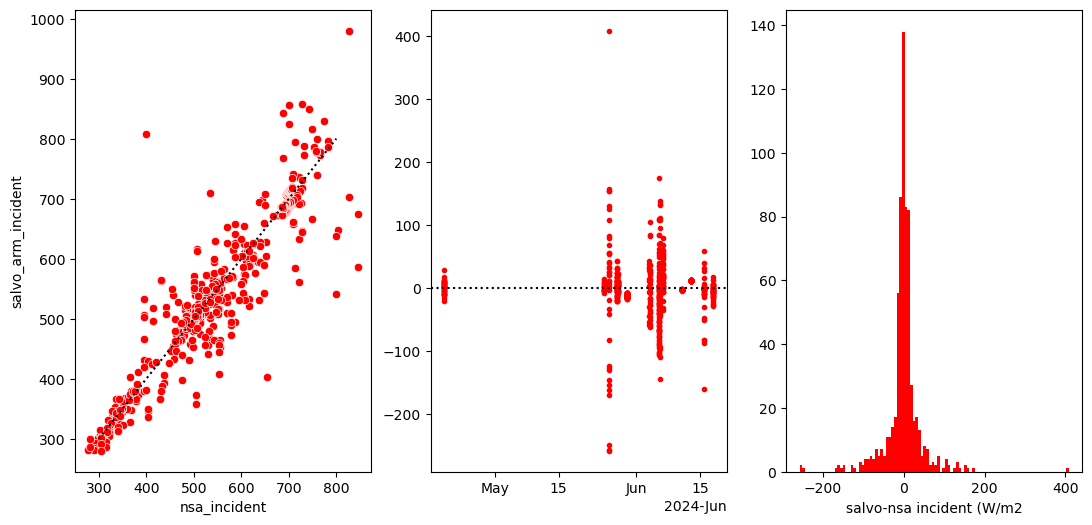

In [129]:
f, axs = plt.subplots(1, 3, figsize=(13, 6))

sns.scatterplot(data=df_comp, x='nsa_incident', y='salvo_arm_incident', ax=axs[0], color='r')
axs[0].plot([300, 800], [300, 800], 'k:')

axs[1].plot(df_comp['diff_nsa'], marker='.', linestyle='', color='r')
axs[1].axhline(y=0, color='k', linestyle=':')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

axs[2].hist(df_comp['diff_nsa'], bins=100, color='r')
axs[2].set_xlabel('salvo-nsa incident (W/m2')

In [19]:
df_temp = line_date_agg(df, 'incident_solar_W_m2')

In [20]:
df_temp.xs('arm', level='site').groupby('date_akdt').agg(['mean', 'std', 'count'])

incident_solar_W_m2                    \
                                   mean         std count   
date_akdt                                                   
2024-04-19 14:24:00          359.330488   17.348832    41   
2024-05-24 14:24:00          469.335238   11.634987    21   
2024-05-25 14:24:00          712.937805  140.514810    41   
2024-05-27 14:24:00          515.688780   18.879725    41   
2024-05-29 14:24:00          686.096341    6.061868    41   
2024-06-03 14:24:00          437.612976   73.087934    42   
2024-06-05 14:24:00          543.276910   53.695427    42   
2024-06-06 14:24:00          524.532927   31.399296    41   
2024-06-10 14:24:00          706.980488    2.200072    41   
2024-06-12 14:24:00          713.598537    3.695040    41   
2024-06-15 14:24:00          687.774286   30.019103    42   
2024-06-17 14:24:00          305.142195   16.926380    41   

                                          meantime_akdt               
                                                   mean    std count  
date_akdt                                                             
2024-04-19 14:24:00 2024-04-19 13:27:57.073170688-08:00 0 days    41  
2024-05-24 14:24:00 2024-05-24 15:58:05.714285824-08:00 0 days    21  
2024-05-25 14:24:00 2024-05-25 14:57:23.414634240-08:00 0 days    41  
2024-05-27 14:24:00 2024-05-27 12:32:21.951219456-08:00 0 days    41  
2024-05-29 14:24:00 2024-05-29 15:30:24.878048768-08:00 0 days    41  
2024-06-03 14:24:00 2024-06-03 13:47:57.209302528-08:00 0 days    42  
2024-06-05 14:24:00 2024-06-05 17:58:36.774193664-08:00 0 days    42  
2024-06-06 14:24:00 2024-06-06 14:40:39.512195072-08:00 0 days    41  
2024-06-10 14:24:00 2024-06-10 15:15:26.341463552-08:00 0 days    41  
2024-06-12 14:24:00 2024-06-12 13:27:13.170731776-08:00 0 days    41  
2024-06-15 14:24:00 2024-06-15 14:28:55.714285568-08:00 0 days    42  
2024-06-17 14:24:00 2024-06-17 13:12:20.487804672-08:00 0 days    41

In [105]:
start_date = pd.Timestamp('2024-06-12T00:00:00+00:00')
end_date = pd.Timestamp('2024-06-14T00:00:00+00:00')

df.xs((slice(start_date, end_date), 'arm', 'incident_solar_W_m2'), level=('timestamp_akdt', 'site', 'variable'),
     drop_level=False)

value
timestamp_akdt            site location position repetition wavelength variable                   
2024-06-12 13:16:00-08:00 arm  line     200.0    1.0        NaN        incident_solar_W_m2  705.43
2024-06-12 13:17:00-08:00 arm  line     195.0    1.0        NaN        incident_solar_W_m2  706.09
2024-06-12 13:18:00-08:00 arm  line     190.0    1.0        NaN        incident_solar_W_m2  707.09
                                        185.0    1.0        NaN        incident_solar_W_m2  707.43
2024-06-12 13:19:00-08:00 arm  line     180.0    1.0        NaN        incident_solar_W_m2  708.09
                                        175.0    1.0        NaN        incident_solar_W_m2  709.09
2024-06-12 13:20:00-08:00 arm  line     170.0    1.0        NaN        incident_solar_W_m2  709.42
                                        165.0    1.0        NaN        incident_solar_W_m2  709.09
2024-06-12 13:21:00-08:00 arm  line     160.0    1.0        NaN        incident_solar_W_m2  709.76
                                        155.0    1.0        NaN        incident_solar_W_m2  710.09
2024-06-12 13:22:00-08:00 arm  line     150.0    1.0        NaN        incident_solar_W_m2  710.42
                                        145.0    1.0        NaN        incident_solar_W_m2  711.75
2024-06-12 13:23:00-08:00 arm  line     140.0    1.0        NaN        incident_solar_W_m2  711.75
                                        135.0    1.0        NaN        incident_solar_W_m2  713.08
2024-06-12 13:24:00-08:00 arm  line     130.0    1.0        NaN        incident_solar_W_m2  712.42
                                        125.0    1.0        NaN        incident_solar_W_m2  713.08
2024-06-12 13:25:00-08:00 arm  line     120.0    1.0        NaN        incident_solar_W_m2  714.41
                                        115.0    1.0        NaN        incident_solar_W_m2  713.75
2024-06-12 13:26:00-08:00 arm  line     110.0    1.0        NaN        incident_solar_W_m2  714.41
                                        105.0    1.0        NaN        incident_solar_W_m2  714.41
2024-06-12 13:27:00-08:00 arm  line     100.0    1.0        NaN        incident_solar_W_m2  714.41
                                        95.0     1.0        NaN        incident_solar_W_m2  714.43
2024-06-12 13:28:00-08:00 arm  line     90.0     1.0        NaN        incident_solar_W_m2  715.10
2024-06-12 13:29:00-08:00 arm  line     85.0     1.0        NaN        incident_solar_W_m2  715.10
                                        80.0     1.0        NaN        incident_solar_W_m2  715.77
2024-06-12 13:30:00-08:00 arm  line     75.0     1.0        NaN        incident_solar_W_m2  715.77
2024-06-12 13:31:00-08:00 arm  line     70.0     1.0        NaN        incident_solar_W_m2  716.45
                                        65.0     1.0        NaN        incident_solar_W_m2  716.45
2024-06-12 13:32:00-08:00 arm  line     60.0     1.0        NaN        incident_solar_W_m2  717.12
                                        55.0     1.0        NaN        incident_solar_W_m2  716.45
2024-06-12 13:33:00-08:00 arm  line     50.0     1.0        NaN        incident_solar_W_m2  716.46
2024-06-12 13:34:00-08:00 arm  line     45.0     1.0        NaN        incident_solar_W_m2  716.46
                                        40.0     1.0        NaN        incident_solar_W_m2  716.46
2024-06-12 13:35:00-08:00 arm  line     35.0     1.0        NaN        incident_solar_W_m2  717.13
                                        30.0     1.0        NaN        incident_solar_W_m2  716.46
                                        25.0     1.0        NaN        incident_solar_W_m2  716.46
2024-06-12 13:36:00-08:00 arm  line     20.0     1.0        NaN        incident_solar_W_m2  716.47
2024-06-12 13:37:00-08:00 arm  line     15.0     1.0        NaN        incident_solar_W_m2  718.13
                                        10.0     1.0        NaN        incident_solar_W_m2  717.80
                                  

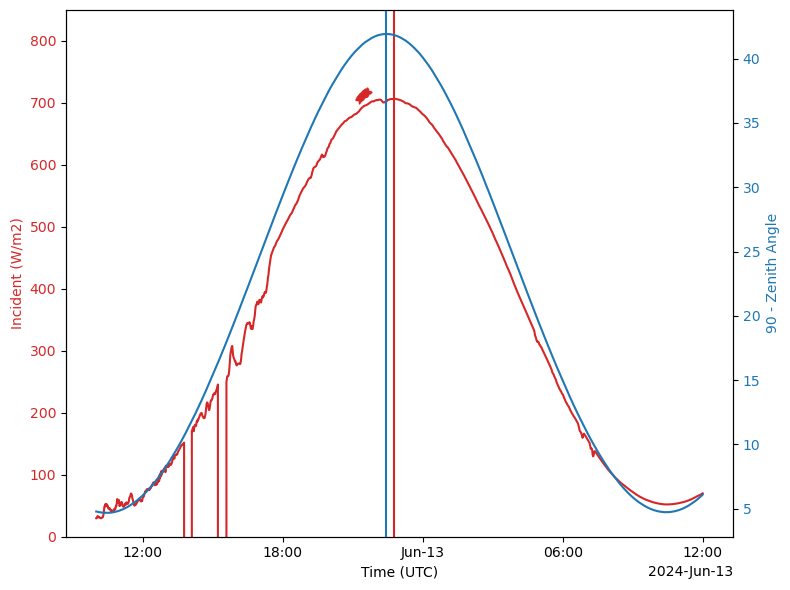

In [21]:
# Plot incident solar and zenith angle
start_date = pd.Timestamp('2024-06-12T10:00:00+00:00')
end_date = pd.Timestamp('2024-06-13T12:00:00+00:00')

df_temp = df.xs((slice(start_date, end_date), 'arm', 'incident_solar_W_m2'), level=('timestamp_akdt', 'site', 'variable'),
     drop_level=False).reset_index()

fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:red'
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Incident (W/m2)', color=color)
ax1.plot(df_gml.loc[start_date:end_date]['incident_solar_W_m2'], color=color)
ax1.plot(df_temp['timestamp_akdt'], df_temp['value'], color=color, marker='+', linestyle=None)
ax1.axvline(x=df_gml.loc[start_date:end_date]['incident_solar_W_m2'].idxmax(), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 850])

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('90 - Zenith Angle', color=color)  # we already handled the x-label with ax1
ax2.plot(90 - df_gml.loc[start_date:end_date]['zen'])
ax2.axvline(x=(90 - df_gml.loc[start_date:end_date]['zen']).idxmax(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
plt.show()

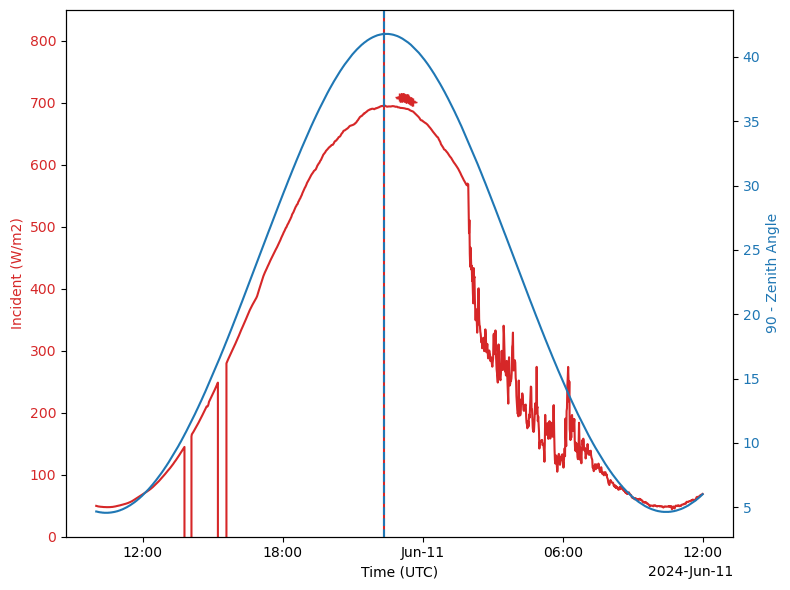

In [22]:
# Plot incident solar and zenith angle
start_date = pd.Timestamp('2024-06-10T10:00:00+00:00')
end_date = pd.Timestamp('2024-06-11T12:00:00+00:00')

df_temp = df.xs((slice(start_date, end_date), 'arm', 'incident_solar_W_m2'), level=('timestamp_akdt', 'site', 'variable'),
     drop_level=False).reset_index()

fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:red'
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Incident (W/m2)', color=color)
ax1.plot(df_gml.loc[start_date:end_date]['incident_solar_W_m2'], color=color)
ax1.plot(df_temp['timestamp_akdt'], df_temp['value'], color=color, marker='+', linestyle=None)
ax1.axvline(x=df_gml.loc[start_date:end_date]['incident_solar_W_m2'].idxmax(), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 850])

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('90 - Zenith Angle', color=color)  # we already handled the x-label with ax1
ax2.plot(90 - df_gml.loc[start_date:end_date]['zen'])
ax2.axvline(x=(90 - df_gml.loc[start_date:end_date]['zen']).idxmax(), color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
plt.show()

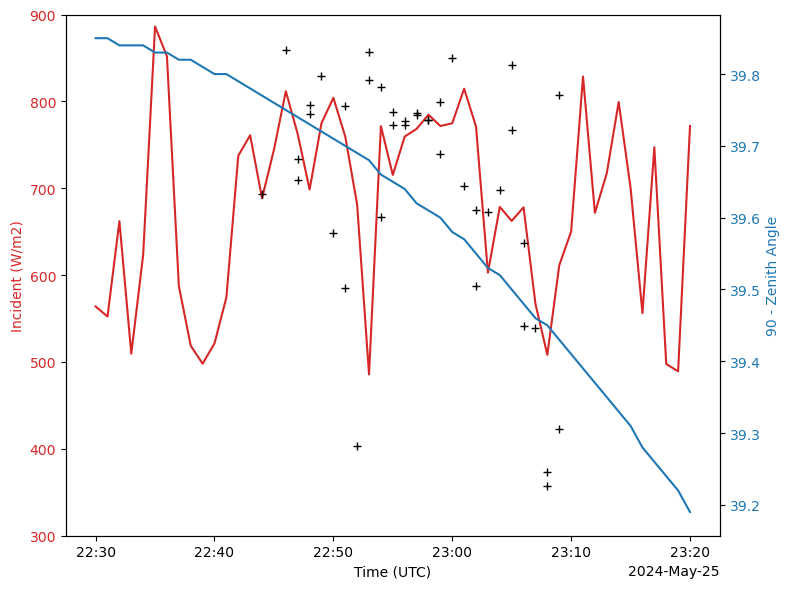

In [125]:
# Plot incident solar and zenith angle
start_date = pd.Timestamp('2024-05-25T22:30:00+00:00')
end_date = pd.Timestamp('2024-05-25T23:20:00+00:00')

df_temp = df.xs((slice(start_date, end_date), 'arm', 'incident_solar_W_m2'), level=('timestamp_akdt', 'site', 'variable'),
     drop_level=False).reset_index()

fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:red'
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Incident (W/m2)', color=color)
ax1.plot(df_gml.loc[start_date:end_date]['incident_solar_W_m2'], color=color)
ax1.plot(df_temp['timestamp_akdt'], df_temp['value'], color='k', marker='+', linestyle='')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([300, 900])

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('90 - Zenith Angle', color=color)  # we already handled the x-label with ax1
ax2.plot(90 - df_gml.loc[start_date:end_date]['zen'])
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
plt.show()

In [23]:
# Investigate melt rates.

df_temp = line_date_agg(df, 'snow_depth_m')
df_temp.groupby(['site','date_akdt']).mean()

In [27]:
df_temp

snow_depth_m  \
site date_akdt           position                 
arm  2024-04-19 14:24:00 0.0              0.477   
                         1.0              0.419   
                         2.0              0.544   
                         3.0              0.573   
                         4.0              0.572   
...                                         ...   
ice  2024-06-18 14:24:00 196.0            0.137   
                         197.0            0.132   
                         198.0            0.096   
                         199.0            0.199   
                         200.0            0.203   

                                                        meantime_akdt  
site date_akdt           position                                      
arm  2024-04-19 14:24:00 0.0      2024-04-19 11:10:25.287014912-08:00  
                         1.0      2024-04-19 11:10:25.287014912-08:00  
                         2.0      2024-04-19 11:10:25.287014912-08:00  
                         3.0      2024-04-19 11:10:25.287014912-08:00  
                         4.0      2024-04-19 11:10:25.287014912-08:00  
...                                                               ...  
ice  2024-06-18 14:24:00 196.0    2024-06-18 13:32:30.502139392-08:00  
                         197.0    2024-06-18 13:32:30.502139392-08:00  
                         198.0    2024-06-18 13:32:30.502139392-08:00  
                         199.0    2024-06-18 13:32:30.502139392-08:00  
                         200.0    2024-06-18 13:32:30.502139392-08:00  

[7838 rows x 2 columns]

In [ ]:
# two ways of looking at mean melt rates, could look a diff of mean snow depth over time. Note that when patches are melted out
# they will have zero melt rates, and these will get averaged in causing the melt rate to tail off.
# alternatively, could just look at melt rates where we actually have snow.

# figure out how to create 'time difference' dataframe

# also look in icepack at what happens when we have patchy snow cover, what happens to melt energy